<a href="https://colab.research.google.com/github/on-the-mender-riv/test/blob/master/Evaluate_Topic_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluate Topic Model in Python: Latent Dirichlet Allocation (LDA)
## できるだけgenismを使った前処理を考える

In [0]:
# Importing modules
import pandas as pd
import os

## データのダウンロード

In [0]:
# show upload dialog
from google.colab import files
uploaded = files.upload()

Saving fake.csv to fake.csv


In [0]:
df = pd.read_csv('fake.csv', encoding='utf-8')
df.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [0]:
df.shape

(12999, 20)

In [0]:
df.columns

Index(['uuid', 'ord_in_thread', 'author', 'published', 'title', 'text',
       'language', 'crawled', 'site_url', 'country', 'domain_rank',
       'thread_title', 'spam_score', 'main_img_url', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'type'],
      dtype='object')

In [0]:
# 不要な列を削除
df_1 = df[df['language']=='english']
df_2 = df_1.drop(['uuid', 'ord_in_thread', 'author', 'published', 'title',
       'language', 'crawled', 'site_url', 'country', 'domain_rank',
       'thread_title', 'spam_score', 'main_img_url', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'type'], axis=True)

df_2 = df_2.sample(1000) # 1000文書をサンプリングして使う
df_2['text'] = df_2['text'].astype(str)
df_2.reset_index(drop=True, inplace=True)
df_2.head()

,text
0,Doctors Restore Ken Burns’ Full-Color Vision A...
1,"November 7, 2016 - Aleksey Ilyashevich, Polit..."
2,"71 Views November 17, 2016 GOLD , KWN , KWN II..."
3,"Bias bashers More Beer, Less Vodka as Russians..."
4,"Posted on November 6, 2016 It seems the more '..."


## テキストのクリーニング

In [0]:
# reモジュールをインポート
import re

# 句読点を削除
df_2['text_clean'] = df_2['text'].map(lambda x: re.sub('[,\.!?]', '', x))
# 大文字を小文字に揃える
df_2['text_clean'] = df_2['text_clean'].map(lambda x: x.lower())

df_2['text_clean'][:1]

0    doctors restore ken burns’ full-color vision a...
Name: text_clean, dtype: object

In [0]:
# gensimのsimple_preprocessをインポート
import gensim
from gensim.utils import simple_preprocess
# from gensim.utils import simple_tokenize

# 英単語をトークン化する関数を定義
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# def sent_to_tokens(sentences):
#     for sentence in sentences:
#         yield(gensim.utils.simple_tokenize(sentence))

# 文字列をリストに格納し，トークン化する
data = df_2.text_clean.values.tolist()
data_words = list(sent_to_words(data))
# token_words = list(sent_to_tokens(data))

print(data_words[:1])
#print(token_words[:1])

[['doctors', 'restore', 'ken', 'burns', 'full', 'color', 'vision', 'after', 'removing', 'massive', 'tumor', 'from', 'filmmaker', 'visual', 'cortex', 'close', 'vol', 'issue', 'news', 'celebrities', 'entertainment', 'healthcare', 'cleveland', 'speaking', 'to', 'reporters', 'following', 'the', 'successful', 'eight', 'hour', 'procedure', 'tuesday', 'neurosurgeons', 'at', 'the', 'cleveland', 'clinic', 'confirmed', 'they', 'had', 'removed', 'golf', 'ball', 'sized', 'tumor', 'from', 'the', 'visual', 'cortex', 'of', 'filmmaker', 'ken', 'burns', 'restoring', 'the', 'documentarian', 'ability', 'to', 'see', 'in', 'full', 'color', 'we', 're', 'happy', 'to', 'report', 'that', 'the', 'surgery', 'went', 'smoothly', 'and', 'beginning', 'today', 'mr', 'burns', 'will', 'no', 'longer', 'be', 'limited', 'to', 'perceiving', 'the', 'world', 'in', 'shades', 'of', 'black', 'white', 'and', 'sepia', 'and', 'will', 'instead', 'be', 'able', 'to', 'experience', 'the', 'entire', 'spectrum', 'of', 'hues', 'that', 'm

## 自然言語処理モジュールで単語を削減

In [0]:
# genismのPrasesモデルでbigramを作成する

# bigramのパラメーター
min_count = 5
threshold = 10

# bigramとtrigramを生成
bigram = gensim.models.Phrases(data_words, min_count=min_count, threshold=threshold) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=threshold)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [0]:
# 英語用の自然言語処理モジュールnltkをインポート
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

# ストップワードを指定
stop_words = stopwords.words('english')
stop_words.extend(['com', 'edu', 'subject', 'lines', 'organization', 'would', 'article', 'could'])

# 見出し語化のための関数
def get_wordnet_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV}
  return tag_dict.get(tag, wordnet.NOUN)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# ストップワードを取り除く関数
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# N-gram(連語)を作る関数
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# 見出し語化(lemmatization)する関数
def texts_lemmatization(texts):
    # lemmatizerを初期化
    lemmatizer = WordNetLemmatizer()
    texts_out = []
    
    # 見出し語化する
    for j in range(len(texts)):
      sentence = texts[j]
      texts_out.append([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sentence])
    return texts_out

In [0]:
# ストップワードを除去
data_words_nostops = remove_stopwords(data_words)
# Bigramを生成
data_words_bigrams = make_bigrams(data_words_nostops)
# 見出し語化する
data_words_lemmatized = texts_lemmatization(data_words_bigrams)

print(data_words_lemmatized[:1])

[['doctor', 'restore', 'ken', 'burn', 'full', 'color', 'vision', 'remove', 'massive', 'tumor', 'filmmaker', 'visual', 'cortex', 'close', 'vol', 'issue', 'news', 'celebrity', 'entertainment', 'healthcare', 'cleveland', 'speak', 'reporter', 'follow', 'successful', 'eight', 'hour', 'procedure', 'tuesday', 'neurosurgeon', 'cleveland', 'clinic', 'confirm', 'remove', 'golf', 'ball', 'size', 'tumor', 'visual', 'cortex', 'filmmaker', 'ken', 'burn', 'restore', 'documentarian', 'ability', 'see', 'full', 'color', 'happy', 'report', 'surgery', 'go', 'smoothly', 'begin', 'today', 'mr', 'burn', 'longer', 'limited', 'perceive', 'world', 'shade', 'black', 'white', 'sepia', 'instead', 'able', 'experience', 'entire', 'spectrum', 'hue', 'u', 'take', 'grant', 'say', 'dr', 'amrita', 'singh', 'note', 'year_old', 'director', 'producer', 'civil_war', 'prohibition', 'jazz', 'awaken', 'anesthesia', 'report', 'marvel', 'vividness', 'surroundings', 'human', 'face', 'photograph', 'appear', 'removal', 'tumor', 'als

## dictionaryとcopusを定義

In [0]:
import gensim.corpora as corpora

# 単語辞書を生成
id2word = corpora.Dictionary(data_words_lemmatized)
# コーパス(bag of words)を生成
corpus = [id2word.doc2bow(text) for text in data_words_lemmatized]

# コーパスを確認
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 5), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 2), (23, 2), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 2), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 2), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 2), (91, 2), (92, 1), (93, 1), (94, 2), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 2), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1),

In [0]:
# 辞書を確認
print(id2word.token2id)

{'ability': 0, 'able': 1, 'add': 2, 'additional': 3, 'also': 4, 'amrita': 5, 'anesthesia': 6, 'anymore': 7, 'appear': 8, 'awaken': 9, 'balance': 10, 'ball': 11, 'begin': 12, 'black': 13, 'built': 14, 'burn': 15, 'cause': 16, 'celebrity': 17, 'center': 18, 'civil_war': 19, 'cleveland': 20, 'clinic': 21, 'close': 22, 'color': 23, 'confirm': 24, 'considerably': 25, 'correct': 26, 'cortex': 27, 'daily': 28, 'detail': 29, 'director': 30, 'doctor': 31, 'documentarian': 32, 'dr': 33, 'drift': 34, 'ear': 35, 'eight': 36, 'entertainment': 37, 'entire': 38, 'experience': 39, 'eyesight': 40, 'face': 41, 'filmmaker': 42, 'filter': 43, 'follow': 44, 'full': 45, 'give': 46, 'go': 47, 'golf': 48, 'grant': 49, 'happy': 50, 'headline': 51, 'healthcare': 52, 'hour': 53, 'hue': 54, 'human': 55, 'image': 56, 'inner': 57, 'inside': 58, 'instead': 59, 'intense': 60, 'issue': 61, 'jazz': 62, 'ken': 63, 'lean': 64, 'left': 65, 'like': 66, 'limited': 67, 'longer': 68, 'make': 69, 'marvel': 70, 'massive': 71, '

In [0]:
# bag of wordsを確認
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 1),
  ('able', 1),
  ('add', 1),
  ('additional', 1),
  ('also', 1),
  ('amrita', 1),
  ('anesthesia', 1),
  ('anymore', 1),
  ('appear', 1),
  ('awaken', 1),
  ('balance', 1),
  ('ball', 1),
  ('begin', 1),
  ('black', 1),
  ('built', 1),
  ('burn', 5),
  ('cause', 1),
  ('celebrity', 1),
  ('center', 1),
  ('civil_war', 1),
  ('cleveland', 2),
  ('clinic', 1),
  ('close', 2),
  ('color', 2),
  ('confirm', 1),
  ('considerably', 1),
  ('correct', 1),
  ('cortex', 2),
  ('daily', 1),
  ('detail', 1),
  ('director', 1),
  ('doctor', 1),
  ('documentarian', 1),
  ('dr', 2),
  ('drift', 1),
  ('ear', 1),
  ('eight', 1),
  ('entertainment', 1),
  ('entire', 1),
  ('experience', 1),
  ('eyesight', 1),
  ('face', 1),
  ('filmmaker', 2),
  ('filter', 1),
  ('follow', 1),
  ('full', 2),
  ('give', 1),
  ('go', 2),
  ('golf', 1),
  ('grant', 1),
  ('happy', 1),
  ('headline', 1),
  ('healthcare', 1),
  ('hour', 1),
  ('hue', 1),
  ('human', 1),
  ('image', 1),
  ('inner', 1),
  ('

## パイロットモデルを生成

In [0]:
# LDAのモデルを生成
num_topics = 10
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [0]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.018*"gold" + 0.009*"year" + 0.008*"economy" + 0.008*"market" + '
  '0.007*"dollar" + 0.006*"world" + 0.006*"trade" + 0.005*"economic" + '
  '0.005*"debt" + 0.005*"price"'),
 (1,
  '0.012*"people" + 0.009*"one" + 0.008*"say" + 0.006*"get" + 0.006*"woman" + '
  '0.006*"go" + 0.005*"right" + 0.005*"see" + 0.005*"want" + 0.005*"life"'),
 (2,
  '0.016*"trump" + 0.009*"obama" + 0.008*"american" + 0.006*"president" + '
  '0.006*"country" + 0.005*"u" + 0.005*"support" + 0.005*"policy" + '
  '0.004*"political" + 0.004*"state"'),
 (3,
  '0.009*"say" + 0.008*"camp" + 0.008*"protester" + 0.007*"muslim" + '
  '0.007*"pipeline" + 0.007*"protest" + 0.007*"police" + 0.006*"report" + '
  '0.005*"refugee" + 0.005*"attack"'),
 (4,
  '0.014*"say" + 0.011*"election" + 0.010*"clinton" + 0.009*"trump" + '
  '0.006*"hillary_clinton" + 0.006*"go" + 0.006*"state" + 0.005*"vote" + '
  '0.005*"donald_trump" + 0.005*"make"'),
 (5,
  '0.020*"russia" + 0.017*"u" + 0.012*"russian" + 0.011*"war" + '
  '0.007

In [0]:
from gensim.models import CoherenceModel

# パプレキシティの計算
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# コヒーレンスの計算(u_mass)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_lemmatized, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.64367554476842

Coherence Score:  -1.6560089033267065


## トピック数を決定

In [0]:
# コヒーレンスを計算する関数
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute u_mass coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
# トピックの数を変えながらモデルを生成し，コヒーレンスの値を取得
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_lemmatized, start=2, limit=20, step=2)

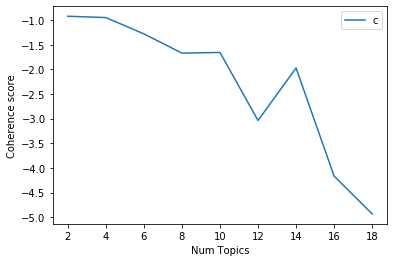

In [0]:
import matplotlib.pyplot as plt

# Show graph
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [0]:
# トピック数ごとコヒーレンス
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of -0.9205
Num Topics = 4  has Coherence Value of -0.9476
Num Topics = 6  has Coherence Value of -1.2784
Num Topics = 8  has Coherence Value of -1.6687
Num Topics = 10  has Coherence Value of -1.656
Num Topics = 12  has Coherence Value of -3.0367
Num Topics = 14  has Coherence Value of -1.9715
Num Topics = 16  has Coherence Value of -4.1665
Num Topics = 18  has Coherence Value of -4.9344


In [0]:
# import numpy as np
# import tqdm

In [0]:
# バリデーションスキーム

# grid = {}
# grid['Validation_Set'] = {}

# トピック数の範囲
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# Alpha
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# Beta
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# Validation sets
# num_of_docs = len(corpus)
# corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
#                # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
#                # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
#                corpus]

# corpus_title = ['100% Corpus']

# model_results = {'Validation_Set': [],
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }

In [0]:
# Can take a long time to run
# if 1 == 1:
#     pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
#     # iterate through validation corpuses
#     for i in range(len(corpus_sets)):
#         # iterate through number of topics
#         for k in topics_range:
#             # iterate through alpha values
#             for a in alpha:
#                 # iterare through beta values
#                 for b in beta:
#                     # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
#                                                   k=k, a=a, b=b)
#                     # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a)
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)
                    
#                     pbar.update(1)
#     df_results = pd.DataFrame(model_results)
#     pbar.close()

In [0]:
# # コヒーレンスが最大になるセット
# df_results[df_results['Coherence']==df_results['Coherence'].max()]

In [0]:
# df_results.groupby('Topics').Coherence.agg('mean')

In [0]:
# Build LDA model
# num_topics = 6
# lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=num_topics, 
#                                        random_state=100,
#                                        chunksize=100,
#                                        passes=10,
#                                        per_word_topics=True)

In [0]:
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

## ベースラインのモデル

In [0]:
# LDAのモデルを生成
num_topics = 14
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## トピック可視化

In [0]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import math

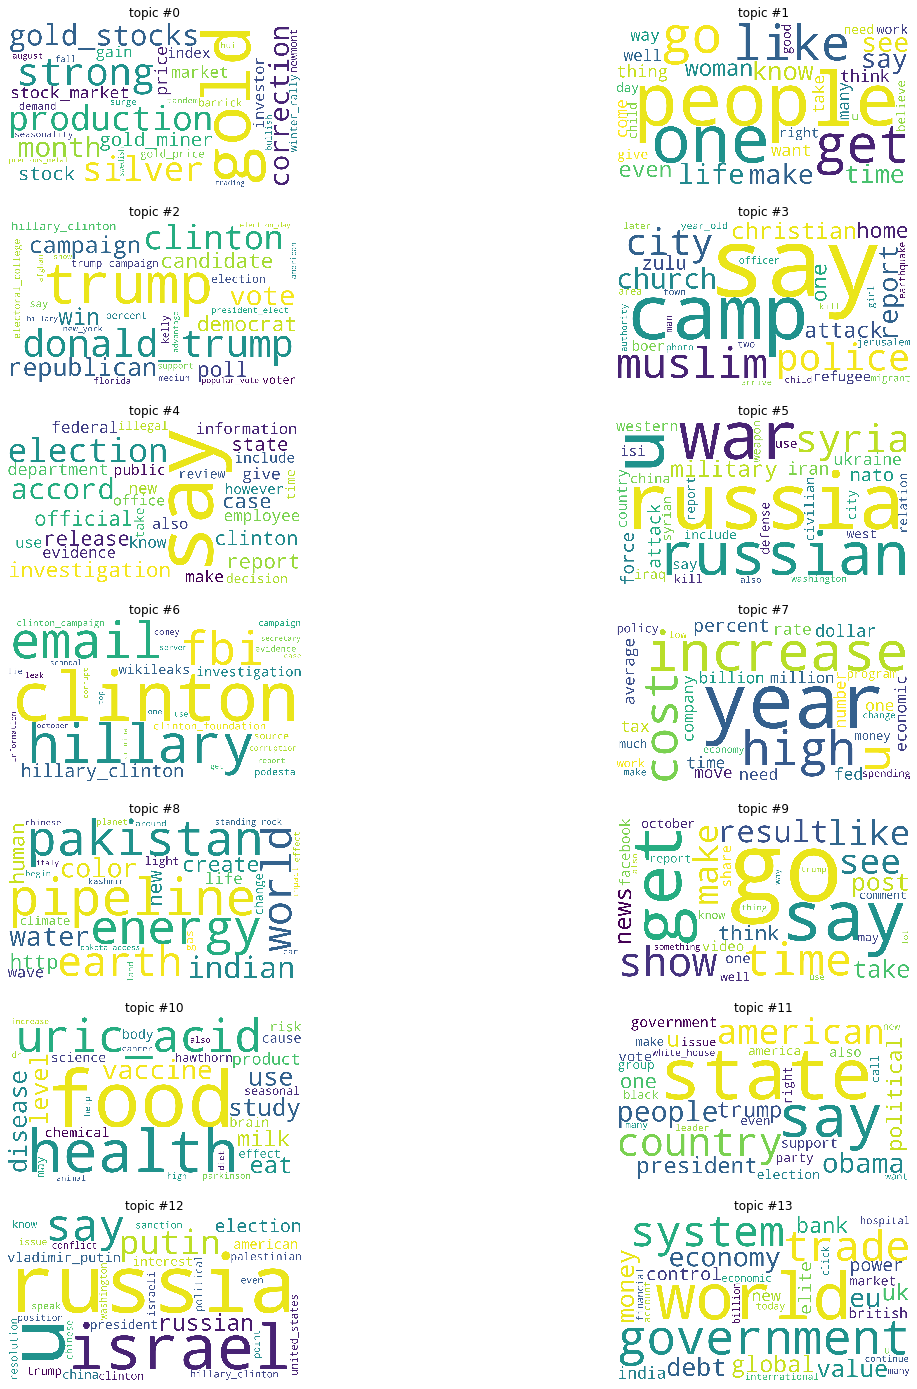

<Figure size 1440x2160 with 0 Axes>

In [0]:
topics = lda_model.show_topics(formatted=False)

fig, axs = plt.subplot(ncols=2, nrows=math.ceil(lda_model.num_topics/2), figsize=(20,25))
axs = axs.flatten()

plt.figure(figsize=(20,30))
for i,t in enumerate(range((lda_model.num_topics))):

    x = dict(lda_model.show_topic(t, 30))
    im = WordCloud(background_color='white',
                   max_words=1000,
                   width=1600,
                   height=900,
                   random_state=0).generate_from_frequencies(x)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('topic #' +str(t))

plt.tight_layout()
plt.show()

# plt.savefig('wordcloud.png')

In [0]:
# 文書ごとに主なトピックを書き出す関数

def format_topics_sentences(ldamodel=None, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    return(sent_topics_df)

In [0]:
# 関数を使って文書ごとの尤もらしいトピックを出力
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']
df_topic_and_original = pd.concat([df_dominant_topic, df_2], axis=1)
df_topic_and_original.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,text,text_clean
0,0,5.0,0.2893,"russia, u, war, russian, syria, military, nato...",Doctors Restore Ken Burns’ Full-Color Vision A...,doctors restore ken burns’ full-color vision a...
1,1,7.0,0.2997,"year, increase, high, cost, u, percent, dollar...","November 7, 2016 - Aleksey Ilyashevich, Polit...",november 7 2016 - aleksey ilyashevich politru...
2,2,7.0,0.2387,"year, increase, high, cost, u, percent, dollar...","71 Views November 17, 2016 GOLD , KWN , KWN II...",71 views november 17 2016 gold kwn kwn ii ki...
3,3,9.0,0.4807,"go, say, get, time, show, like, see, make, res...","Bias bashers More Beer, Less Vodka as Russians...",bias bashers more beer less vodka as russians ...
4,4,13.0,0.6451,"world, government, system, trade, economy, eu,...","Posted on November 6, 2016 It seems the more '...",posted on november 6 2016 it seems the more 'c...
5,5,11.0,0.7206,"state, say, country, american, people, obama, ...",Obama Won’t Go Away After He’s Done. That’s Go...,obama won’t go away after he’s done that’s goo...
6,6,11.0,0.6972,"state, say, country, american, people, obama, ...",This post was originally published on this sit...,this post was originally published on this sit...
7,7,1.0,0.2908,"people, one, get, go, like, life, make, see, s...",Next Swipe left/right UK manages to go half an...,next swipe left/right uk manages to go half an...
8,8,3.0,0.3287,"say, camp, muslim, police, city, church, repor...",Archives Michael’s Latest Video What Is Causin...,archives michael’s latest video what is causin...
9,9,1.0,0.5813,"people, one, get, go, like, life, make, see, s...","October 30, 2016 at 1:18 PM \nRight now we are...",october 30 2016 at 1:18 pm \nright now we are ...


## 各文書のトピック分布

### 表形式

In [0]:
# 各トピックの最も典型的な文書を書き出す

# dfを初期化
sent_topics_sorteddf = pd.DataFrame()
# トピックごとに集約
sent_topics_outdf_grpd = df_topic_and_original.groupby('Dominant_Topic')
# Topic_Perc_Contribが最大のものを取得
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, grp.sort_values(['Topic_Perc_Contrib'], ascending=False).head(1)], axis=0)

# dfを整形
sent_topics_sorteddf.reset_index(drop=True, inplace=True)
sent_topics_sorteddf.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'text', 'text_clean']

sent_topics_sorteddf

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,text,text_clean
0,583,0.0,0.9423,"gold, strong, production, silver, gold_stocks,...",How to contact WikiLeaks? What is Tor? Tips fo...,how to contact wikileaks what is tor tips for ...
1,265,1.0,0.7478,"people, one, get, go, like, life, make, see, s...","USA CREATED ISIS ,ALL EUROPEAN KNOW ABOUT THAT...",usa created isis all european know about that ...
2,42,2.0,0.8150,"trump, donald_trump, clinton, vote, republican...",Poll: Trump pulls ahead in Florida GOP's Rubio...,poll: trump pulls ahead in florida gop's rubio...
3,596,3.0,0.7223,"say, camp, muslim, police, city, church, repor...",Man in Freddy Krueger Costume Crashes Hallowee...,man in freddy krueger costume crashes hallowee...
4,140,4.0,0.7843,"say, election, accord, investigation, case, re...","DaisyLuther.com October 31, 2016 \nAccording t...",daisyluthercom october 31 2016 \naccording to ...
5,35,5.0,0.7759,"russia, u, war, russian, syria, military, nato...",NATO Accuses Russian Warships of Targeting Syr...,nato accuses russian warships of targeting syr...
6,245,6.0,0.8381,"clinton, hillary, email, fbi, hillary_clinton,...","— jewels (@Jewels817) October 28, 2016 \nNeera...",— jewels (@jewels817) october 28 2016 \nneera ...
7,26,7.0,0.7755,"year, increase, high, cost, u, percent, dollar...",The statistic that Obamacare plan premiums are...,the statistic that obamacare plan premiums are...
8,10,8.0,0.5975,"pipeline, pakistan, energy, earth, world, indi...",Headlines from Siberia reveal an incident of u...,headlines from siberia reveal an incident of u...
9,74,9.0,0.8323,"go, say, get, time, show, like, see, make, res...",Michael Moore is totally failing at getting Tr...,michael moore is totally failing at getting tr...


In [0]:
# # 各文書ごとの最有力トピックを書き出す
# all_topics = lda_model.get_document_topics(corpus, minimum_probability=0)

# # 値を格納するリストを初期化
# dominant_topic = []
# dominant_topic_prob_a = []
# dominant_topic_words = []

# # 文書ごとに値を取得する処理
# for sent in range(len(corpus)):
#   x = sorted(all_topics[sent], key=lambda x: (x[1]), reverse=True)

#   y = x[0][0]
#   z = x[0][1]
#   dominant_topic.append(y) # 最有力トピック番号を取得
#   dominant_topic_prob_a.append(z)  # 最有力トピック確率を取得

#   topic_bag = lda_model.show_topics(formatted=False)[y]
#   topic_words = []

#   for i in range(len(topic_bag[1])):
#     topic_words.append(topic_bag[1][i][0]) # 最有力トピックの代表語を取得

#   dominant_topic_words.append(topic_words) # 最有力トピックの代表語リストを取得

# df_dominant_topics_prob_wd = pd.DataFrame({'topic #' : dominant_topic,
#                                            'topic_prob' : dominant_topic_prob_a,
#                                            'topic_words' : dominant_topic_words})
# df_topic_plus_original = pd.concat([df_dominant_topics_prob_wd, df_2], axis=1)
# df_topic_plus_original.head(20)

In [0]:
# x = sorted(all_topics[0], key=lambda x: (x[1]), reverse=True)

# y = x[0][0]
# z = x[0][1]

# print(x)
# print(y)
# print(z)
# print(lda_model.show_topics(formatted=False)[6])

In [0]:
# # 各トピックの最も典型的な文書を書き出す

# most_tipical_text_of_topics = pd.DataFrame()
# most_tipical_text_grpd = df_topic_plus_original.groupby('topic #')

# for i, grp in most_tipical_text_grpd:
#     most_tipical_text_of_topics = pd.concat([most_tipical_text_of_topics, grp.sort_values(['topic_prob'], ascending=False).head(1)], axis=0)

# most_tipical_text_of_topics

In [0]:
# 文書ごとに各トピックの潜在確率を書き出す
all_topics = lda_model.get_document_topics(corpus, minimum_probability=0)

# 値を格納するリストを初期化
probs_list = []

# 文書ごとに値を取得する処理
for j in range(len(corpus)):
  probs =[]
  for i in range(num_topics):
    probs.append(all_topics[j][i][1]) # i番目のトピックの確率を取得
  probs_list.append(probs) # j番目の文書の各トピック確率を取得

probs_df = pd.DataFrame(probs_list)
probs_df.columns = ['topic #{}'.format(i) for i in range(num_topics)]
probs_df.head(20)

,topic #0,topic #1,topic #2,topic #3,topic #4,topic #5,topic #6,topic #7,topic #8,topic #9,topic #10,topic #11,topic #12,topic #13
0,0.000462,0.177843,0.000795,0.001438,0.079052,0.289292,0.001714,0.011066,0.032609,0.118722,0.000538,0.022922,0.001820,0.261718
1,0.000084,0.221390,0.000144,0.040062,0.037687,0.179373,0.014211,0.299690,0.026207,0.018077,0.010431,0.119492,0.002867,0.030286
2,0.231088,0.024817,0.000387,0.000692,0.002271,0.000886,0.000835,0.238671,0.000590,0.138533,0.000262,0.121759,0.059032,0.180187
3,0.028374,0.004452,0.000325,0.000566,0.008902,0.057003,0.000685,0.132686,0.000496,0.480657,0.113714,0.025479,0.000820,0.145847
4,0.000640,0.206085,0.001100,0.001927,0.007676,0.042697,0.002308,0.002466,0.001676,0.011583,0.000744,0.073474,0.002509,0.645141
5,0.000375,0.052434,0.031606,0.001134,0.002832,0.001475,0.001351,0.040153,0.000978,0.129672,0.000436,0.720569,0.015158,0.001827
6,0.003552,0.036231,0.023824,0.002519,0.008558,0.005870,0.041028,0.110066,0.001783,0.051751,0.000089,0.697216,0.017136,0.000376
7,0.010156,0.290798,0.001192,0.002149,0.096558,0.002679,0.002568,0.047188,0.201652,0.026150,0.000806,0.203433,0.002778,0.111920
8,0.001831,0.198110,0.002654,0.328674,0.031623,0.011386,0.009470,0.054170,0.073868,0.184639,0.008851,0.049670,0.007143,0.037910
9,0.000335,0.581296,0.020833,0.001012,0.013295,0.063901,0.047426,0.010256,0.000871,0.069218,0.000389,0.105788,0.010096,0.075287


In [0]:
# metric は色々あるので、ケースバイケースでどれかひとつ好きなものを選ぶ。
# method も色々あるので、ケースバイケースでどれかひとつ好きなものを選ぶ。
# from scipy.cluster.hierarchy import linkage, dendrogram

# result1 = linkage(df_probs, 
#                   metric = 'braycurtis', 
#                   #metric = 'canberra', 
#                   #metric = 'chebyshev', 
#                   #metric = 'cityblock', 
#                   #metric = 'correlation', 
#                   #metric = 'cosine', 
#                   #metric = 'euclidean', 
#                   #metric = 'hamming', 
#                   #metric = 'jaccard', 
#                   #method= 'single')
#                   method = 'average')
#                   #method= 'complete')
#                   #method='weighted')
# plt.figure(figsize=(10,10))
# dendrogram(result1)
# plt.title("Dendrogram")
# plt.ylabel("Threshold")
# plt.show()

### ビジュアル

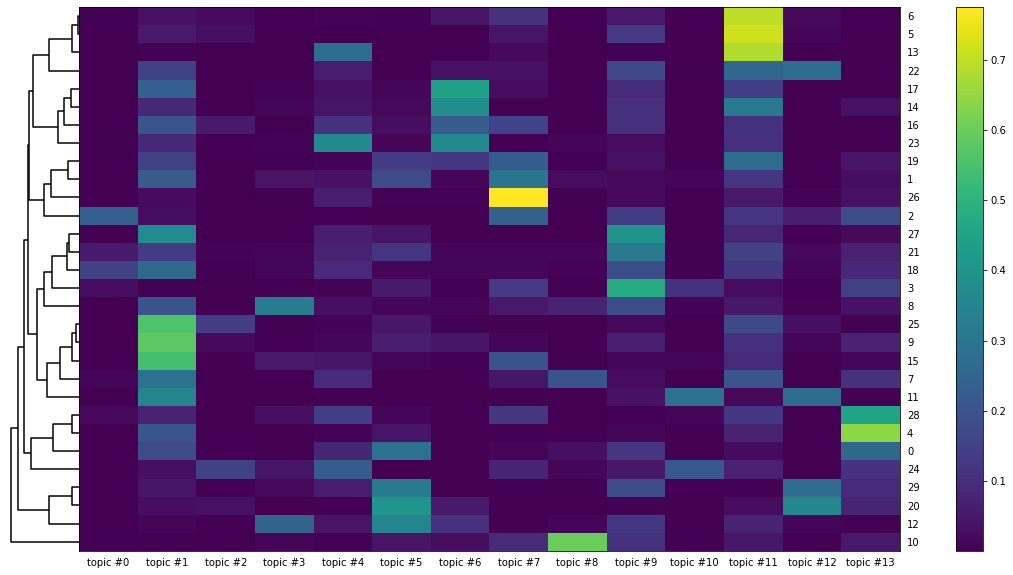

In [0]:
# 文書ごとに各トピックの潜在確率を可視化し，近い文書同士をグルーピング

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from mpl_toolkits.axes_grid1 import make_axes_locatable

df_toshow = probs_df.head(30)

plt.figure(figsize=(20,10))

### クラスタリングの尺度を選ぶ ###
metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation','cosine', 'euclidean', 'hamming', 'jaccard', 'dice', 'jensenshannon',
           'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath',
           'sqeuclidean', 'yule']
methods = ['single', 'average', 'complete', 'weighted']

metric = metrics[5] # コサイン類似度
method = methods[1] # 群平均

main_axes = plt.gca()
divider = make_axes_locatable(main_axes)

plt.sca(divider.append_axes("left", 1.0, pad=0))

ylinkage =linkage(pdist(df_toshow, metric=metric), method=method, metric=metric)
ydendro = dendrogram(ylinkage, orientation='left', no_labels=True, distance_sort='descending', link_color_func=lambda x: 'black')
plt.gca().set_axis_off()
df_toshow = df_toshow.iloc[[df_toshow.index[i] for i in ydendro['leaves']]]

plt.sca(main_axes)
plt.imshow(df_toshow, aspect='auto', interpolation='none')
plt.colorbar()
plt.gca().yaxis.tick_right()
plt.xticks(range(df_toshow.shape[1]), df_toshow.columns)
plt.yticks(range(df_toshow.shape[0]), df_toshow.index)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.gca().invert_yaxis()
plt.show()